# Using Satellite Imagery to Predict Food supply

*Objective*: Test to what extent satellite data of greenness can predict subsequent crop price.



## Context

In order to check the satellite data of greeness weekly satellite images from Brazil were downloaded in the period of 2000 to 2017 from NOAA STAR: <https://www.star.nesdis.noaa.gov/smcd/emb/vci/VH/vh_browseByCountry.php>

The agriculture data was downloaded from Agricultural data from the United Nations Food and Agricultural Organization: <http://www.fao.org/faostat/en/> 

The item that was selected for the analysis is Value of Agricultural Production

## Background removal

The first step we took in order to reduce the noise from the images was to remove the background, the other countries and the ocean / rivers. Since the idea of the challenge is to practice ML techniques, we used a k-means technique to identify RGBs similar to the ones we wanted to get rid of. So 5 cluster k-means was trained, and the clusters hich contained the following RGBs were removed:
210, 210, 255 - Water
185, 185, 185 - Other Countries
255, 255, 255 - Background

Resulting in the image following image:

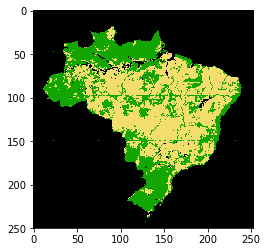

In [1]:
from satellite_image_handler import SatelliteImageHandler

#Initialized the class
stl_image_handler = SatelliteImageHandler()

#Call the background removal visualization
stl_image_handler.visualize_background_removal()

## Image scoring

After the background removal, I trained a model to give a score to the picture based on the green and yellow/brown intensity, the model would score from 6 (more intense) to 4 (less intense) for greens  and 3 (less intense) to 1 (more intense) for yellow/brown. Other colors were scored with 0, and are removed  in other steps.

To train the model we used three color scales with different intensities for green and other 3 for yellow and one color scale for the other colors as follows:

Green (Score 6):
![Green (Score 6)](colorScales/green3.png)

Green (Score 5):
![Green (Score 5)](colorScales/green2.png)

Green (Score 4):
![Green (Score 4)](colorScales/green1.png)

Yellow (Score 3):
![Yellow (Score 3)](colorScales/yellow1.png)

Yellow (Score 2):
![Yellow (Score 2)](colorScales/yellow2.png)

Yellow (Score 1):
![Yellow (Score 1)](colorScales/yellow3.png)

Other Colors (Score 0):
![Other Colors (Score 0)](colorScales/otherColors.png)

For the model training, the images were resized to 100x50 pixels so that they have the same quantity of pixels. The pixels from the above image were splitted in 80/20 train/test datasets. We tried three different models which resulted in the following f-measures:
* SVM - 0.98
* Random Forest - 0.9967
* Extra Trees - 0.9999

So we chose the extra trees model to work with.

## Image Scoring Visualization

In order to check how the model performed when evaluating a satellite image, we manually choose one greenish image and one yellish image to test the performance as follows:

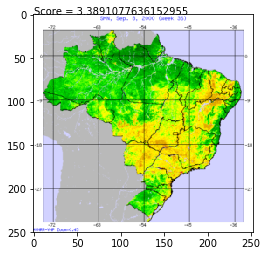

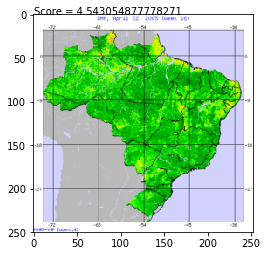

In [2]:
#Call the model building method
score_model = stl_image_handler.build_image_model()

#Call the images visualization 
stl_image_handler.visualize_model_with_opposite_images(score_model)

The first image got a score of 3.39, while the second one 4.54 of "greenish" what seems a good evaluation. In order to test if it was not a coincidence we also got some random images to test:

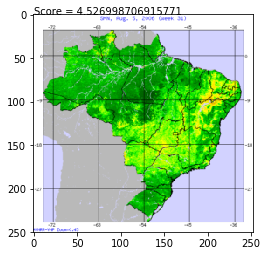

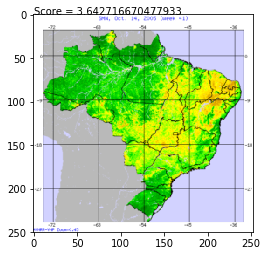

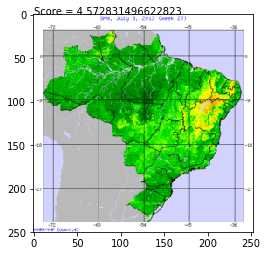

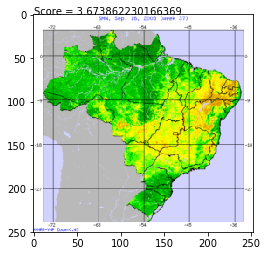

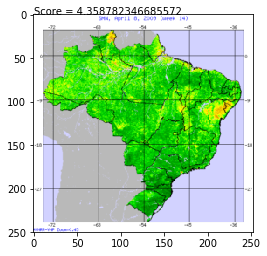

In [4]:
#Get 5 random images scores
stl_image_handler.visualize_model_with_random_images(score_model, 5)

The scores still look coherent. So we chose this model to use for the image greenish scoring.

## Agriculture data analysis

Now that we have trained a scoring model to detect the image how green is the image, we will check if the image greenish of aa given year affects the agriculture prices of that given year. In order to do so, we will check if the prices and the greenish variates together.

Since we have several diferent items in the dataset, we normalized the values by subtracting the mean and dividing by the standard deviation for each item. Then we got the mean of those items by year for comparison. Since the data presented a increasing trend we also subtracted the rolling mean with a window=3 in order to remove the trend from the variation. The resulting data can be visualized in the following plot:

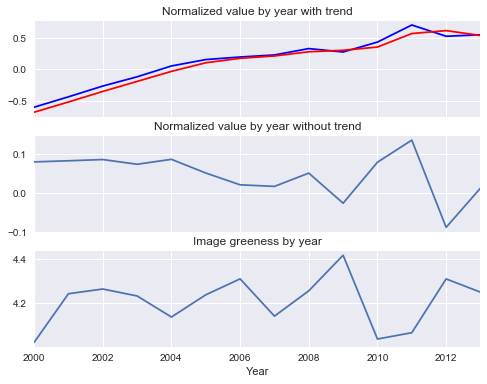

In [3]:
from agriculture_data_analysis import AgricultureDataAnalysis

pixels_to_remove = stl_image_handler.get_pixels_to_remove()
agr_data_analysis = AgricultureDataAnalysis(pixels_to_remove, score_model, stl_image_handler.satellite_image_size)
agr_data_analysis.general_average_analysis()

The correlation between the "Normalized value without trend" and the "Image greeness by year" was -0.64, indicating a relevant negative correlation between the the prices and the satellite greenish. This can be partially explained with the fact that a greenish year may lead to a bigger production, the bigger production can increase the offer making the price fall.

## Agriculture data analysis per item

But this may not be true for all the studied items in the report. To analyze it, we have measured the correlation per item, so that we can have a better insight of each item. To simplify this report we will only analyse the top 10 correlations and the top 10 negative correlations as shown below:

In [4]:
agr_data_analysis.analyze_performance_per_item()

Top 10 negative correlations
    Correlation       Item
58    -0.673953    Oranges
32    -0.303874    Linseed
70    -0.286736   Rapeseed
63    -0.274886  Peas, dry
85    -0.259012        Tea
0     -0.243773     Apples
3     -0.213050     Barley
35    -0.201971       Maté
68    -0.196919    Quinces
12    -0.171686    Cassava
Top 10 positive correlations
    Correlation                    Item
59     0.672068            Palm kernels
60     0.626100                 Papayas
15     0.438761                Coconuts
40     0.360992  Meat indigenous, horse
9      0.359704               Buckwheat
64     0.340188     Pepper (piper spp.)
1      0.299726                Avocados
31     0.299492        Lemons and limes
2      0.252191                 Bananas
78     0.239332                 Sorghum


So, as we can see in the data above, when analysing by item, we can have both strong correlations and strong negative correlations with the image greenish, depending on how the weather affects the production of each item

## Conclusion

Given the data, it was possible to notice that there is a correlation (negative or positive, depending on the item) between the image greenish and the products price, suggesting that a greener year can affect the price of the products overall.

## Next steps

On the data analysis, I hypothesized that the correlation between the price and the green image is due to a increase/decrease in the production, but I haven't checked the production to confirm my hypothesis, what leaves a Gap in my report. A next step would be to download the production data and cross with the price data to confirm it.

## Git repository

For more details about the used models and analysis the project can be found in the following git repo:

<https://github.com/fredcaram/SatelliteImageChallenge>